#  PASO 1: Carga, ETL y Exploración

🔹 Celda 1: Carga del archivo original

Esta celda carga el archivo original de la EPH (Encuesta Permanente de Hogares) desde la carpeta `data/raw`. Se utiliza el separador `;` porque el archivo está en formato `.txt` con ese formato. Se visualizan las primeras filas para verificar que la carga fue exitosa.

In [7]:
import pandas as pd

# Cambiá el nombre del archivo si usás otro
ruta = '../data/raw/usu_individual_T423.txt'

# Cargar archivo
df = pd.read_csv(ruta_nueva, sep=";", encoding="latin1", low_memory=False)

# Filtrar solo ocupados y desocupados
df = df_nuevo[df["ESTADO"].isin([1, 2])].copy()
df_nuevo["empleado"] = df_nuevo["ESTADO"].apply(lambda x: 1 if x == 1 else 0)

print("✔️ Datos cargados correctamente.")
df_nuevo.head()

✔️ Datos cargados correctamente.


C:\Users\Bel\AppData\Local\Temp\ipykernel_15120\3525399822.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_nuevo[df["ESTADO"].isin([1, 2])].copy()


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH,empleado
0,TQRMNOSUWHLMKQCDEFNFF00852219,2023,4,1,1,1,41,N,7,370,...,12,0,12,12.0,12,NaN,12.0,12,0,1
2,TQRMNOTXQHKOLMCDEGNFJ00794590,2023,4,1,1,1,44,N,17,281,...,7,"216666,67",8,8.0,7,NaN,8.0,6,387,1
3,TQRMNOTXQHKOLMCDEGNFJ00794590,2023,4,1,2,1,44,N,17,281,...,7,"216666,67",8,8.0,7,NaN,8.0,6,387,1
6,TQRMNORVYHJMLPCDEGNFJ00794591,2023,4,1,3,1,44,N,17,165,...,12,0,12,12.0,12,NaN,12.0,12,0,1
9,TQRMNOQVSHKMKPCDEOJAH00793041,2023,4,1,1,1,44,N,93,85,...,6,200000,7,8.0,6,NaN,8.0,7,97,1


🔹 Celda 2: Renombrar columnas para vista simplificada

Aquí se renombran algunas columnas para facilitar la lectura del dataset. Por ejemplo, `CH04` se convierte en `sexo`, y `CH06` en `edad`. Esto no afecta el resto del código, ya que se usa solo para visualizar una tabla más comprensible en esta etapa inicial.

In [8]:
# Crear una vista con algunas columnas y nombres más legibles para exploración
df_renombrado = df_nuevo.rename(columns={
    "CH04": "sexo",
    "CH06": "edad",
    "ESTADO": "estado_laboral",
    "CH10": "nivel_educativo",
    "AGLOMERADO": "aglomerado"})

# Mostrar primeras filas
df_renombrado[["sexo", "edad", "estado_laboral", "nivel_educativo", "aglomerado"]].head()


,sexo,edad,estado_laboral,nivel_educativo,aglomerado
0,1,60,1,2,7
2,1,34,1,2,17
3,2,32,1,2,17
6,2,43,1,2,17
9,1,47,1,2,93


🔹 Celda 3: ETL – Filtrado de empleados y desempleados

En esta celda se filtran únicamente las personas que están ocupadas (`ESTADO = 1`) o desocupadas (`ESTADO = 2`). Se crea una nueva variable llamada `empleado`, que toma el valor 1 para personas ocupadas y 0 para desocupadas. Esto simplifica la tarea de clasificación para los modelos posteriores.

In [9]:
# Filtrar solo ocupados y desocupados
df = df[df["ESTADO"].isin([1, 2])].copy()
df["empleado"] = df["ESTADO"].apply(lambda x: 1 if x == 1 else 0)
print("✔️ Filtrados empleados y desempleados.")
df["empleado"].value_counts().rename(index={0: "Desempleado", 1: "Empleado"})


✔️ Filtrados empleados y desempleados.


empleado
Empleado       21312
Desempleado     1055
Name: count, dtype: int64

🔹 Celda 4: Exploración – Gráficos iniciales

Este gráfico permite observar cómo se distribuyen las edades según si las personas están empleadas o desempleadas.
Es útil para detectar diferencias visibles entre los grupos y tener un primer acercamiento a los patrones que podrían
ayudar al modelo a predecir la condición laboral.

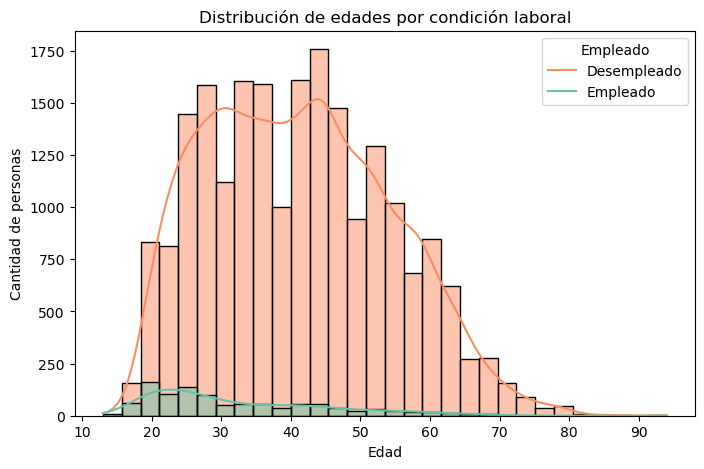

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de edad por condición laboral
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="CH06", hue="empleado", bins=30, kde=True, palette="Set2")
plt.title("Distribución de edades por condición laboral")
plt.xlabel("Edad")
plt.ylabel("Cantidad de personas")
plt.legend(title="Empleado", labels=["Desempleado", "Empleado"])
plt.show()


# PASO 2: Selección, transformación y guardado

🔹 Celda 5: Selección de variables y preprocesamiento

Se seleccionan las variables que se usarán como predictoras y se identifican como numéricas o categóricas. Luego se imputan (rellenan) los valores faltantes. Para las numéricas se usa la mediana, y para las categóricas se usa la categoría más frecuente. Esto permite mantener la mayor cantidad de datos sin eliminar filas.

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Variables seleccionadas
columnas = ['CH04', 'CH06', 'CH10', 'CH15_COD', 'AGLOMERADO',
            'PP04B_COD', 'PP07H', 'PP07K', 'ITF', 'empleado']

df_modelo = df[columnas].copy()

# Identificar variables
vars_numericas = ['CH06', 'PP07H', 'ITF']
vars_categoricas = ['CH04', 'CH10', 'CH15_COD', 'AGLOMERADO', 'PP04B_COD', 'PP07K']

# Imputación
imp_num = SimpleImputer(strategy='median')
df_modelo[vars_numericas] = imp_num.fit_transform(df_modelo[vars_numericas])

imp_cat = SimpleImputer(strategy='most_frequent')
df_modelo[vars_categoricas] = imp_cat.fit_transform(df_modelo[vars_categoricas])


🔹 Celda 6: Codificación y escalado

Las variables categóricas se convierten en variables binarias (one-hot encoding) para que puedan ser utilizadas por los algoritmos de machine learning. Las variables numéricas se escalan (normalizan) para que todas tengan una magnitud comparable, lo cual mejora el rendimiento de ciertos modelos como la regresión logística.

In [12]:
# Codificación one-hot
df_modelo = pd.get_dummies(df_modelo, columns=vars_categoricas, drop_first=True)

# Escalado
scaler = StandardScaler()
df_modelo[vars_numericas] = scaler.fit_transform(df_modelo[vars_numericas])

# Separar X e y
X = df_modelo.drop(columns='empleado')
y = df_modelo['empleado']


🔹 Celda 7: Guardar archivo limpio

Una vez que los datos están limpios, completos y listos para entrenar modelos, se guardan en un nuevo archivo llamado `datos_limpios.csv` dentro de la carpeta `data/processed`. Este archivo será utilizado en la siguiente notebook para entrenar y evaluar distintos modelos de predicción.

In [14]:
# Guardar archivo limpio en la ruta correcta
ruta_salida = '../data/processed/.txt'
df_export = X.copy()
df_export['empleado'] = y
df_export.to_csv(ruta_salida, index=False)
print("✔️ Archivo guardado en:", ruta_salida)


✔️ Archivo guardado en: ../data/processed/.txt
